# Application of scPI-ZIFA on Cortex

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import time
import warnings
warnings.filterwarnings('ignore')
from scPI import scPI_ZIFA
from utils import *
np.random.seed(1234)
torch.manual_seed(1234)
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

## Clustering

### Load data and fit scPI-ZIFA

In [2]:
data_path = "/home/jzhaoaz/jiazhao/scPI/CORTEX/"
expression_train = np.log(np.loadtxt(data_path + "data_train", dtype='float32') + 1)
expression_test = np.log(np.loadtxt(data_path + "data_test", dtype='float32') + 1)
label_train = np.loadtxt(data_path + "label_train")
print(expression_train.shape, expression_test.shape, label_train.shape)
print("CORTEX dataset: 3005 cells (2253 training, 752 testing), 558 selected highly variable genes.")

(2253, 558) (752, 558) (2253,)
CORTEX dataset: 3005 cells (2253 training, 752 testing), 558 selected highly variable genes.


In [3]:
t_start = time.time()
result, result_test = scPI_ZIFA.fitModel(Y=expression_train, K=10, Y_test=expression_test)
t_end = time.time()
print('Computational time = %1.1f minutes.' % ((t_end-t_start)/60.0))

Computational time = 1.4 minutes.


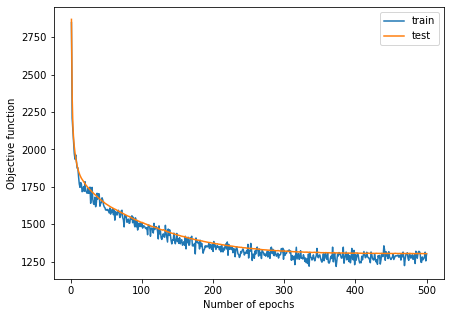

In [4]:
visualize_loss(result['epochs'], result['losses'], result_test['losses'])

### Evaluate clustering scores (ASW, NMI, ARI) and visualize latent distance

In [5]:
latent = result['latent']

In [6]:
scores = cluster_scores(latent, 7, label_train)
print('Clustering scores [ASW, NMI, ARI] = [%f, %f, %f].' % (scores[0], scores[1], scores[2]))

Clustering scores [ASW, NMI, ARI] = [0.251991, 0.800783, 0.748128].


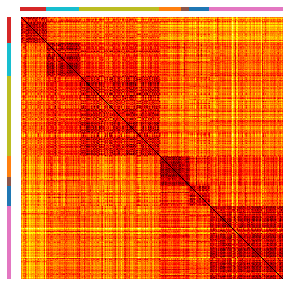

In [7]:
visualize_distance_cortex(latent, label_train)

### Evaluate log-likelihood on test dataset

In [8]:
A = result['A']
mu = result['mu']
W = result['W']
lam = result['lam']
K = 10
N, D = expression_test.shape
logllh = ZIFA_logllh(expression_test, A, mu, W, lam, N, D, K)
print('Log-likelihood on test dataset = %f.' % logllh)

Log-likelihood on test dataset = -1138.594628.


## Imputation

### Load randomly dropout data and fit scPI_ZIFA

In [9]:
data_path = "/home/jzhaoaz/jiazhao/scPI/CORTEX/"
X_zero = np.log(np.loadtxt(data_path + "imputation/X_zero.txt", dtype='float32') + 1)
N, D = X_zero.shape
i = np.load(data_path + "imputation/i.npy")
j = np.load(data_path + "imputation/j.npy")
ix = np.load(data_path + "imputation/ix.npy")
X_true = np.loadtxt(data_path + "data_train", dtype='float32')

In [10]:
t_start = time.time()
result, result_test = scPI_ZIFA.fitModel(Y=X_zero, K=10, Y_test=None)
t_end = time.time()
print('Computational time = %1.1f minutes.' % ((t_end-t_start)/60.0))

Computational time = 1.3 minutes.


### Evaluate imputation error

In [11]:
A = result["A"]
Z = result["latent"]
mu = result["mu"]
X_impu = np.exp(Z @ A.T + mu.reshape([1, D])) - 1
impu_err = imputation_error(X_impu, X_true, np.exp(X_zero)-1, i, j, ix)
print('Imputation error on randomly dropout data = %f.' % impu_err)

Imputation error on randomly dropout data = 2.193517.
